In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
#from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import tqdm
import copy

from torch.utils.data import DataLoader, Dataset


In [2]:
# model
# Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_dim , hidden_depth=2, embed_dim=128, use_bn=True):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        self.x_dim = x_dim
        self.hidden_depth = hidden_depth
        self.embed_dim = embed_dim
        self.use_bn = use_bn

        assert hidden_depth>=1, 'hidden_depth must be greater than 0!'
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # fc layers
        self.input = nn.Linear(x_dim, embed_dim)
        self.fc_all = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(self.hidden_depth)])
        self.output = nn.Linear(embed_dim, x_dim)

        if self.use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(num_features=embed_dim) for i in range(self.hidden_depth)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #
        h = self.input(x)
        # residue connections
        for i in range(self.hidden_depth):
            h = h + self.act(self.fc_all[i](h)) + embed
            if self.use_bn:
                h = self.bn[i](h)

        h = self.output(h)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None,]
        return h


# Define the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps #(eps,1)
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma**t, device=device)
    return sigma**t


# data set
class MyDataset(Dataset):
    def __init__(self, x_train):
        super().__init__()
        self.x_train = x_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return self.x_train[idx]



def train_model(score_model, x_sample, lr=1e-4, batch_size=1000, n_epochs=5000, print_interval=100):
    dataset = MyDataset(x_sample)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(score_model.parameters(), lr=lr)
    train_loss = []


    for epoch in range(n_epochs):
        avg_loss = 0.
        num_items = 0
        for x in data_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        # Print the averaged training loss so far.
        epoch_avg_loss = avg_loss / num_items
        train_loss.append(epoch_avg_loss)
        if epoch%print_interval==0:
            print(f'epoch: {epoch}\t loss: {epoch_avg_loss}')
    return train_loss


def Euler_Maruyama_sampler(score_prior, marginal_prob_std, diffusion_coeff, score_likelihood=None,
                           batch_size=64,num_steps=500,device='cpu',eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
    the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
    Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, score_prior.x_dim, device=device) \
    * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if score_likelihood is None:
                score = score_prior(x, batch_time_step)
            else:
                score = score_prior(x, batch_time_step) + score_likelihood(x)*torch.relu(1-2*time_step)

            # score = torch.clip(score, min=-100, max=100)

            score_norm = torch.sqrt(torch.mean(score**2, dim=1))
            adj_ratio = torch.ones_like(score_norm)
            tol = 50.
            adj_ratio[score_norm>tol] = tol/score_norm[score_norm>tol]
            # score_norm = torch.clip(score_norm, min=0, max=50)


            score = score*adj_ratio[:,None]

            # print(time_step, score)

            mean_x = x + (g**2)[:, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        # Do not include any noise in the last sampling step.
    return mean_x


In [3]:
# diffusion setup
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


In [4]:
# define obs system
# h(x) = x^3



# def likelihood_1d(x, obs, sigma_obs):
#     return torch.exp(-0.5*(x**3 - obs)**2/sigma_obs**2)

def likelihood_score_1d(x, obs, sigma_obs):
    temp1 = -(x - obs)/sigma_obs**2
    temp2 = 1
    return temp2*temp1


# def likelihood(x, obs, sigma_obs):
#     l1 = likelihood_1d(x[:,0], obs[0], sigma_obs)
#     l2 = likelihood_1d(x[:,1], obs[1], sigma_obs)
#     return l1*l2

def likelihood_score(x, obs, sigma_obs):
    score_d = []
    for d in range(num_dim):
        score_d.append(likelihood_score_1d(x[:,d], obs[d], sigma_obs))
        #score_d[d] = likelihood_score_1d(x[:,d], obs[0], sigma_obs)
    
    sc = torch.stack(score_d, dim=1)
    return sc

# def likelihood_score_damp(x, obs, sigma_obs, c=0.01):
#     sc1 = likelihood_score_1d(x[:,0], obs[0], sigma_obs)
#     sc2 = likelihood_score_1d(x[:,1], obs[1], sigma_obs)
#     sc = torch.stack([sc1, sc2], dim=1)
#     sc_gauss = -(x)/c

    # sc_norm = torch.mean(sc**2, dim=1)
    # gauss_norm = torch.mean(sc_gauss**2, dim=1)
    # sc[sc_norm > gauss_norm] = sc_gauss[sc_norm > gauss_norm]
    # return sc

# filtering setup

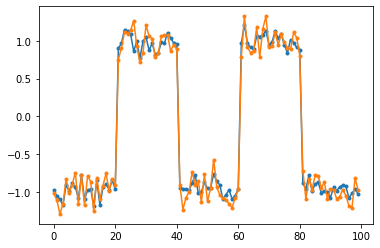

In [12]:
# Problem formulation
# state process setup
Time = 10.
dt = 0.1
num_dim = 1
X_initial = -1 + torch.randn(1) * 0.02
N_T = int(Time//dt+1)
t_path = np.linspace(0, Time, N_T)
sigma_SDE = 0.3


#dt = t_path[1] - t_path[0]


X_path = torch.zeros((N_T, num_dim))
X_path[0] = X_initial.clone()
x_new = X_initial.clone()

for i in range(N_T-1):
    # Generate true state trajectory
    x_old = X_path[i]
    
    x_new[0] = x_old[0] - 4*x_old[0]*(x_old[0]**2 - 1)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    
    X_path[i+1] = x_new
    
    if i==20:
        X_path[i+1] = -X_path[i+1]
    if i==40:
        X_path[i+1] = -X_path[i+1]
    if i==60:
        X_path[i+1] = -X_path[i+1]
    if i==80:
        X_path[i+1] = -X_path[i+1]

# plt.plot(*X_path.T, '.-')
# plt.title('state')
# plt.show()

# get observation
sigma_obs = 0.1

obs_path_true = X_path
obs_path = obs_path_true + np.random.randn(N_T,num_dim)*sigma_obs

# plot
plt.plot(X_path,'.-',label='state')
plt.plot(obs_path,'.-',label='obs')
plt.show()

In [19]:
# initial guess
x0 = torch.tensor(X_initial, dtype=torch.float32, device=device)
sigma0 = 0.2

print(X_initial)


tensor([-0.9761])


C:\Users\10576\AppData\Local\Temp\ipykernel_33200\341100692.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(X_initial, dtype=torch.float32, device=device)


In [20]:
# Training initialize
x_dim = num_dim
hidden_depth  = 2
embed_dim = 50
use_bn = False

score_prior_old = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_new = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_old = score_prior_old.to(device)
score_prior_new = score_prior_new.to(device)

# initial samples
sample_size = 1000
x_init = x0 + torch.randn(sample_size,num_dim, dtype=torch.float32, device=device)*sigma0
train_loss = train_model(score_prior_old, x_sample=x_init, batch_size=sample_size, lr=0.005, n_epochs=600, print_interval=100)

likelihood_score_fn = None
score_prior_new = score_prior_old

epoch: 0	 loss: 10.24169921875
epoch: 100	 loss: 0.24697886407375336
epoch: 200	 loss: 0.23708072304725647
epoch: 300	 loss: 0.1968979388475418
epoch: 400	 loss: 0.12018808722496033
epoch: 500	 loss: 0.11787381768226624


In [21]:
est_all = []
x_prior = x_init.clone()
for i in range(N_T-1):
    print(i)
    
    score_prior_old = score_prior_new
    score_prior_new = copy.deepcopy(score_prior_new)
    
    # sample initial distribution
    x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                                   batch_size=sample_size,num_steps=600,device=device)
    est_all.append(torch.mean(x_init, dim=0).cpu().numpy())


    # solve for forward SDE (prediction)
    x_prior[:,0] = x_init[:,0] - 4 * x_init[:,0] * ( x_init[:,0]**2 - 1)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)


    print('est: ',est_all[i])
    print('state: ',X_path[i])


    # train model for prior distribution
    train_loss = train_model(score_prior_new, x_sample=x_prior,
                             batch_size=sample_size,lr=0.01, n_epochs=600, print_interval=200)

    # new observation
    obs_current = np.array(obs_path[i+1,:])

    # update likelihood function
    likelihood_score_fn = functools.partial(likelihood_score, obs=obs_current, sigma_obs=sigma_obs)
    # likelihood_score_fn = functools.partial(likelihood_score_damp, obs=obs_current, sigma_obs=sigma_obs, c=0.1)
    # next iteration


# last estimation
# sample initial distribution
x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                               batch_size=sample_size,num_steps=500,device=device)
est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

#
est_all = np.array(est_all)


0


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0067397]
state:  tensor([-0.9761])
epoch: 0	 loss: 0.16854742169380188
epoch: 200	 loss: 0.16197845339775085
epoch: 400	 loss: 0.14384399354457855
1


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1019939]
state:  tensor([-1.0530])
epoch: 0	 loss: 0.11627040058374405
epoch: 200	 loss: 0.1362123042345047
epoch: 400	 loss: 0.14490874111652374
2


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.2596233]
state:  tensor([-1.0986])
epoch: 0	 loss: 0.13973702490329742
epoch: 200	 loss: 0.14055891335010529
epoch: 400	 loss: 0.13224156200885773
3


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1571805]
state:  tensor([-1.1745])
epoch: 0	 loss: 0.12448398023843765
epoch: 200	 loss: 0.12887370586395264
epoch: 400	 loss: 0.11972954124212265
4


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.84878373]
state:  tensor([-0.9026])
epoch: 0	 loss: 0.12619882822036743
epoch: 200	 loss: 0.13909882307052612
epoch: 400	 loss: 0.13799771666526794
5


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9909377]
state:  tensor([-0.9895])
epoch: 0	 loss: 0.13154779374599457
epoch: 200	 loss: 0.13906051218509674
epoch: 400	 loss: 0.13112692534923553
6


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.90977085]
state:  tensor([-0.8862])
epoch: 0	 loss: 0.12542074918746948
epoch: 200	 loss: 0.1250031590461731
epoch: 400	 loss: 0.12266453355550766
7


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.7650274]
state:  tensor([-0.9282])
epoch: 0	 loss: 0.14198248088359833
epoch: 200	 loss: 0.10876132547855377
epoch: 400	 loss: 0.12769366800785065
8


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1397947]
state:  tensor([-1.0857])
epoch: 0	 loss: 0.1499573141336441
epoch: 200	 loss: 0.12490798532962799
epoch: 400	 loss: 0.12153983116149902
9


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8053541]
state:  tensor([-0.7810])
epoch: 0	 loss: 0.13257363438606262
epoch: 200	 loss: 0.12873072922229767
epoch: 400	 loss: 0.14024116098880768
10


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1662457]
state:  tensor([-1.0918])
epoch: 0	 loss: 0.1436464637517929
epoch: 200	 loss: 0.12285777926445007
epoch: 400	 loss: 0.11796259135007858
11


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8022947]
state:  tensor([-0.9784])
epoch: 0	 loss: 0.136199951171875
epoch: 200	 loss: 0.1275305151939392
epoch: 400	 loss: 0.13587823510169983
12


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.87338537]
state:  tensor([-0.9604])
epoch: 0	 loss: 0.10864993929862976
epoch: 200	 loss: 0.11987299472093582
epoch: 400	 loss: 0.08953627943992615
13


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.2202413]
state:  tensor([-1.1827])
epoch: 0	 loss: 0.12899477779865265
epoch: 200	 loss: 0.10168448090553284
epoch: 400	 loss: 0.14322048425674438
14


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.81150055]
state:  tensor([-0.8436])
epoch: 0	 loss: 0.1305840015411377
epoch: 200	 loss: 0.11042855679988861
epoch: 400	 loss: 0.13154864311218262
15


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0826666]
state:  tensor([-1.1773])
epoch: 0	 loss: 0.1306181102991104
epoch: 200	 loss: 0.13358628749847412
epoch: 400	 loss: 0.1298946589231491
16


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9285459]
state:  tensor([-0.9327])
epoch: 0	 loss: 0.12112035602331161
epoch: 200	 loss: 0.12129786610603333
epoch: 400	 loss: 0.11933271586894989
17


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.77747643]
state:  tensor([-0.8995])
epoch: 0	 loss: 0.13736620545387268
epoch: 200	 loss: 0.1207197904586792
epoch: 400	 loss: 0.11838644742965698
18


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.97510463]
state:  tensor([-0.9680])
epoch: 0	 loss: 0.14430111646652222
epoch: 200	 loss: 0.12361730635166168
epoch: 400	 loss: 0.13244055211544037
19


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.84386694]
state:  tensor([-0.8455])
epoch: 0	 loss: 0.1446639597415924
epoch: 200	 loss: 0.1194569543004036
epoch: 400	 loss: 0.1548435240983963
20


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9067544]
state:  tensor([-0.9597])
epoch: 0	 loss: 0.11292926222085953
epoch: 200	 loss: 0.11858880519866943
epoch: 400	 loss: 0.11771879345178604
21


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.61102575]
state:  tensor([0.9001])
epoch: 0	 loss: 1.6441242694854736
epoch: 200	 loss: 0.14461643993854523
epoch: 400	 loss: 0.12594325840473175
22


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8988586]
state:  tensor([0.9661])
epoch: 0	 loss: 0.17128664255142212
epoch: 200	 loss: 0.15598264336585999
epoch: 400	 loss: 0.12610125541687012
23


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.115113]
state:  tensor([1.1491])
epoch: 0	 loss: 0.10588132590055466
epoch: 200	 loss: 0.11133962124586105
epoch: 400	 loss: 0.12309914827346802
24


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0941365]
state:  tensor([1.1242])
epoch: 0	 loss: 0.12289413809776306
epoch: 200	 loss: 0.1121872141957283
epoch: 400	 loss: 0.1252017766237259
25


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1267732]
state:  tensor([1.0839])
epoch: 0	 loss: 0.09900379180908203
epoch: 200	 loss: 0.12874937057495117
epoch: 400	 loss: 0.10066264867782593
26


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.247266]
state:  tensor([0.8611])
epoch: 0	 loss: 0.13185466825962067
epoch: 200	 loss: 0.12206470221281052
epoch: 400	 loss: 0.1229286715388298
27


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.93051684]
state:  tensor([0.9934])
epoch: 0	 loss: 0.11521192640066147
epoch: 200	 loss: 0.09072113782167435
epoch: 400	 loss: 0.14020998775959015
28


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.74367803]
state:  tensor([0.7678])
epoch: 0	 loss: 0.14514988660812378
epoch: 200	 loss: 0.14096184074878693
epoch: 400	 loss: 0.141677588224411
29


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.83958757]
state:  tensor([0.9925])
epoch: 0	 loss: 0.12118734419345856
epoch: 200	 loss: 0.11948461830615997
epoch: 400	 loss: 0.1307607889175415
30


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1830919]
state:  tensor([1.0483])
epoch: 0	 loss: 0.1248009204864502
epoch: 200	 loss: 0.11862633377313614
epoch: 400	 loss: 0.12815530598163605
31


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0502374]
state:  tensor([0.8742])
epoch: 0	 loss: 0.1294487565755844
epoch: 200	 loss: 0.11010564118623734
epoch: 400	 loss: 0.1325339525938034
32


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.029976]
state:  tensor([0.9669])
epoch: 0	 loss: 0.13079901039600372
epoch: 200	 loss: 0.12653090059757233
epoch: 400	 loss: 0.13141702115535736
33


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8018815]
state:  tensor([0.8179])
epoch: 0	 loss: 0.13183359801769257
epoch: 200	 loss: 0.11545735597610474
epoch: 400	 loss: 0.1223406046628952
34


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.85120034]
state:  tensor([0.8447])
epoch: 0	 loss: 0.124697744846344
epoch: 200	 loss: 0.10599582642316818
epoch: 400	 loss: 0.13692699372768402
35


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0559263]
state:  tensor([0.9786])
epoch: 0	 loss: 0.12454501539468765
epoch: 200	 loss: 0.16014862060546875
epoch: 400	 loss: 0.10856039077043533
36


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0651752]
state:  tensor([0.9684])
epoch: 0	 loss: 0.11937906593084335
epoch: 200	 loss: 0.10767032206058502
epoch: 400	 loss: 0.1431170254945755
37


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.069656]
state:  tensor([1.1094])
epoch: 0	 loss: 0.12601014971733093
epoch: 200	 loss: 0.13499249517917633
epoch: 400	 loss: 0.13313469290733337
38


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8814349]
state:  tensor([1.0346])
epoch: 0	 loss: 0.11077355593442917
epoch: 200	 loss: 0.12441645562648773
epoch: 400	 loss: 0.12180237472057343
39


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.94806486]
state:  tensor([0.9721])
epoch: 0	 loss: 0.12796665728092194
epoch: 200	 loss: 0.1341947764158249
epoch: 400	 loss: 0.13757731020450592
40


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.89527804]
state:  tensor([0.9561])
epoch: 0	 loss: 0.1210913360118866
epoch: 200	 loss: 0.1130744144320488
epoch: 400	 loss: 0.12583379447460175
41


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.7443522]
state:  tensor([-0.9420])
epoch: 0	 loss: 2.444668769836426
epoch: 200	 loss: 0.13762658834457397
epoch: 400	 loss: 0.14668144285678864
42


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1983591]
state:  tensor([-0.9566])
epoch: 0	 loss: 0.14222347736358643
epoch: 200	 loss: 0.12023001909255981
epoch: 400	 loss: 0.12696176767349243
43


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0637053]
state:  tensor([-0.9664])
epoch: 0	 loss: 0.11116835474967957
epoch: 200	 loss: 0.1277805119752884
epoch: 400	 loss: 0.11455417424440384
44


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9945884]
state:  tensor([-0.9720])
epoch: 0	 loss: 0.1177368313074112
epoch: 200	 loss: 0.12932667136192322
epoch: 400	 loss: 0.11057387292385101
45


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.75733954]
state:  tensor([-0.8833])
epoch: 0	 loss: 0.13379625976085663
epoch: 200	 loss: 0.12190722674131393
epoch: 400	 loss: 0.142508864402771
46


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9016629]
state:  tensor([-0.7734])
epoch: 0	 loss: 0.13825586438179016
epoch: 200	 loss: 0.11009099334478378
epoch: 400	 loss: 0.13515768945217133
47


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.86575055]
state:  tensor([-1.0188])
epoch: 0	 loss: 0.11543335020542145
epoch: 200	 loss: 0.13325686752796173
epoch: 400	 loss: 0.14200106263160706
48


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1153694]
state:  tensor([-1.0019])
epoch: 0	 loss: 0.11197927594184875
epoch: 200	 loss: 0.1183726042509079
epoch: 400	 loss: 0.10895837098360062
49


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.79134953]
state:  tensor([-0.8741])
epoch: 0	 loss: 0.1491306722164154
epoch: 200	 loss: 0.11828973144292831
epoch: 400	 loss: 0.1318947821855545
50


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1071969]
state:  tensor([-0.9517])
epoch: 0	 loss: 0.11806606501340866
epoch: 200	 loss: 0.12306248396635056
epoch: 400	 loss: 0.12943129241466522
51


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9638122]
state:  tensor([-0.9419])
epoch: 0	 loss: 0.12365654110908508
epoch: 200	 loss: 0.152999609708786
epoch: 400	 loss: 0.1307191401720047
52


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.6049729]
state:  tensor([-0.7648])
epoch: 0	 loss: 0.16820210218429565
epoch: 200	 loss: 0.11379268020391464
epoch: 400	 loss: 0.13115337491035461
53


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.91657495]
state:  tensor([-0.8581])
epoch: 0	 loss: 0.18767280876636505
epoch: 200	 loss: 0.1275498867034912
epoch: 400	 loss: 0.12754444777965546
54


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0368938]
state:  tensor([-0.9065])
epoch: 0	 loss: 0.12095130234956741
epoch: 200	 loss: 0.11190406233072281
epoch: 400	 loss: 0.11449131369590759
55


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0794946]
state:  tensor([-1.0933])
epoch: 0	 loss: 0.12784866988658905
epoch: 200	 loss: 0.13776487112045288
epoch: 400	 loss: 0.11815084517002106
56


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0899136]
state:  tensor([-1.0346])
epoch: 0	 loss: 0.11955169588327408
epoch: 200	 loss: 0.12448830902576447
epoch: 400	 loss: 0.1360602229833603
57


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1480496]
state:  tensor([-0.9738])
epoch: 0	 loss: 0.18954986333847046
epoch: 200	 loss: 0.15740981698036194
epoch: 400	 loss: 0.11283371597528458
58


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1957356]
state:  tensor([-1.0917])
epoch: 0	 loss: 0.11733386665582657
epoch: 200	 loss: 0.133161723613739
epoch: 400	 loss: 0.10756325721740723
59


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0628823]
state:  tensor([-1.0489])
epoch: 0	 loss: 0.1463051438331604
epoch: 200	 loss: 0.1193782389163971
epoch: 400	 loss: 0.12997955083847046
60


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.97347116]
state:  tensor([-0.9616])
epoch: 0	 loss: 0.12747041881084442
epoch: 200	 loss: 0.1311700940132141
epoch: 400	 loss: 0.1505649983882904
61


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.6341123]
state:  tensor([0.9657])
epoch: 0	 loss: 2.075038194656372
epoch: 200	 loss: 0.12417824566364288
epoch: 400	 loss: 0.1217900812625885
62


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.2921207]
state:  tensor([1.2132])
epoch: 0	 loss: 0.12740975618362427
epoch: 200	 loss: 0.12105513364076614
epoch: 400	 loss: 0.13368350267410278
63


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9077598]
state:  tensor([0.9662])
epoch: 0	 loss: 0.12366969883441925
epoch: 200	 loss: 0.1134600043296814
epoch: 400	 loss: 0.11277693510055542
64


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.84882313]
state:  tensor([0.9117])
epoch: 0	 loss: 0.1379992961883545
epoch: 200	 loss: 0.13506609201431274
epoch: 400	 loss: 0.1458006203174591
65


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8740063]
state:  tensor([0.8861])
epoch: 0	 loss: 0.11796900629997253
epoch: 200	 loss: 0.12528587877750397
epoch: 400	 loss: 0.11451070755720139
66


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.161035]
state:  tensor([1.0610])
epoch: 0	 loss: 0.14873634278774261
epoch: 200	 loss: 0.11742538958787918
epoch: 400	 loss: 0.14232367277145386
67


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.7985903]
state:  tensor([1.0565])
epoch: 0	 loss: 0.12766951322555542
epoch: 200	 loss: 0.13755403459072113
epoch: 400	 loss: 0.12917649745941162
68


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.1457021]
state:  tensor([1.0744])
epoch: 0	 loss: 0.1464853137731552
epoch: 200	 loss: 0.12874113023281097
epoch: 400	 loss: 0.13454867899417877
69


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.2973726]
state:  tensor([1.1353])
epoch: 0	 loss: 0.13119801878929138
epoch: 200	 loss: 0.1369829773902893
epoch: 400	 loss: 0.11176234483718872
70


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9140559]
state:  tensor([0.9477])
epoch: 0	 loss: 0.1293942779302597
epoch: 200	 loss: 0.1175895407795906
epoch: 400	 loss: 0.12984293699264526
71


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.9295582]
state:  tensor([0.9831])
epoch: 0	 loss: 0.12730178236961365
epoch: 200	 loss: 0.1327389031648636
epoch: 400	 loss: 0.15573462843894958
72


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0973376]
state:  tensor([1.1320])
epoch: 0	 loss: 0.10498437285423279
epoch: 200	 loss: 0.11350838840007782
epoch: 400	 loss: 0.10467339307069778
73


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.95096266]
state:  tensor([1.0324])
epoch: 0	 loss: 0.10512786358594894
epoch: 200	 loss: 0.12312852591276169
epoch: 400	 loss: 0.11293694376945496
74


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.0796022]
state:  tensor([1.0922])
epoch: 0	 loss: 0.12121984362602234
epoch: 200	 loss: 0.10800033807754517
epoch: 400	 loss: 0.12775340676307678
75


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.98910475]
state:  tensor([0.9431])
epoch: 0	 loss: 0.1548757255077362
epoch: 200	 loss: 0.1261863261461258
epoch: 400	 loss: 0.12343298643827438
76


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.91374636]
state:  tensor([0.8386])
epoch: 0	 loss: 0.13911615312099457
epoch: 200	 loss: 0.1394062042236328
epoch: 400	 loss: 0.1328933984041214
77


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.8964778]
state:  tensor([1.0167])
epoch: 0	 loss: 0.15168826282024384
epoch: 200	 loss: 0.11030364781618118
epoch: 400	 loss: 0.1249675303697586
78


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.093898]
state:  tensor([0.9772])
epoch: 0	 loss: 0.1265104115009308
epoch: 200	 loss: 0.12014564871788025
epoch: 400	 loss: 0.13101913034915924
79


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [1.038386]
state:  tensor([0.9114])
epoch: 0	 loss: 0.12461261451244354
epoch: 200	 loss: 0.1253920942544937
epoch: 400	 loss: 0.10835956037044525
80


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [0.81728715]
state:  tensor([0.8829])
epoch: 0	 loss: 0.10370679944753647
epoch: 200	 loss: 0.11840332299470901
epoch: 400	 loss: 0.1284072995185852
81


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.5524757]
state:  tensor([-0.8821])
epoch: 0	 loss: 1.8422058820724487
epoch: 200	 loss: 0.11529826372861862
epoch: 400	 loss: 0.1408989280462265
82


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0563616]
state:  tensor([-0.9583])
epoch: 0	 loss: 0.1864091157913208
epoch: 200	 loss: 0.11879175901412964
epoch: 400	 loss: 0.14408455789089203
83


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.84788775]
state:  tensor([-0.7757])
epoch: 0	 loss: 0.11902549862861633
epoch: 200	 loss: 0.11609892547130585
epoch: 400	 loss: 0.11375262588262558
84


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9721954]
state:  tensor([-0.9903])
epoch: 0	 loss: 0.11912738531827927
epoch: 200	 loss: 0.13495978713035583
epoch: 400	 loss: 0.11059070378541946
85


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.7996475]
state:  tensor([-0.8936])
epoch: 0	 loss: 0.1594746708869934
epoch: 200	 loss: 0.1207909807562828
epoch: 400	 loss: 0.10249701142311096
86


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.7908718]
state:  tensor([-0.8700])
epoch: 0	 loss: 0.12779633700847626
epoch: 200	 loss: 0.1259303241968155
epoch: 400	 loss: 0.13258051872253418
87


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9358085]
state:  tensor([-1.0110])
epoch: 0	 loss: 0.12521794438362122
epoch: 200	 loss: 0.10455677658319473
epoch: 400	 loss: 0.13430573046207428
88


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8843036]
state:  tensor([-0.9827])
epoch: 0	 loss: 0.13895346224308014
epoch: 200	 loss: 0.12358828634023666
epoch: 400	 loss: 0.13262870907783508
89


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0770286]
state:  tensor([-0.9971])
epoch: 0	 loss: 0.13320133090019226
epoch: 200	 loss: 0.11398916691541672
epoch: 400	 loss: 0.1340622454881668
90


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9728325]
state:  tensor([-1.0749])
epoch: 0	 loss: 0.11838497966527939
epoch: 200	 loss: 0.13687275350093842
epoch: 400	 loss: 0.1316579133272171
91


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.9763017]
state:  tensor([-0.9365])
epoch: 0	 loss: 0.12507182359695435
epoch: 200	 loss: 0.1232370063662529
epoch: 400	 loss: 0.11150677502155304
92


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0832199]
state:  tensor([-0.9807])
epoch: 0	 loss: 0.12208706140518188
epoch: 200	 loss: 0.13904978334903717
epoch: 400	 loss: 0.13324034214019775
93


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.051439]
state:  tensor([-0.9341])
epoch: 0	 loss: 0.13471627235412598
epoch: 200	 loss: 0.10333963483572006
epoch: 400	 loss: 0.11741389334201813
94


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.97005624]
state:  tensor([-0.9071])
epoch: 0	 loss: 0.11603782325983047
epoch: 200	 loss: 0.1293264627456665
epoch: 400	 loss: 0.1282736212015152
95


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.0372769]
state:  tensor([-0.9254])
epoch: 0	 loss: 0.15240228176116943
epoch: 200	 loss: 0.14397326111793518
epoch: 400	 loss: 0.1214587464928627
96


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1719794]
state:  tensor([-1.0784])
epoch: 0	 loss: 0.13370509445667267
epoch: 200	 loss: 0.1432492733001709
epoch: 400	 loss: 0.12241725623607635
97


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-1.1853251]
state:  tensor([-1.0196])
epoch: 0	 loss: 0.12742435932159424
epoch: 200	 loss: 0.12910157442092896
epoch: 400	 loss: 0.1297263503074646
98


  0%|          | 0/600 [00:00<?, ?it/s]

est:  [-0.8350214]
state:  tensor([-0.9577])
epoch: 0	 loss: 0.15094509720802307
epoch: 200	 loss: 0.1465604603290558
epoch: 400	 loss: 0.10877715051174164


  0%|          | 0/500 [00:00<?, ?it/s]

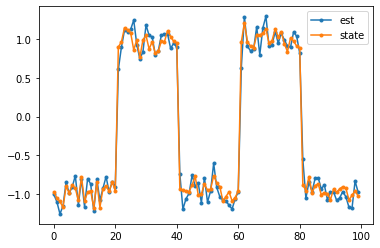

In [24]:
plt.plot(est_all,'.-',label='est')
plt.plot(X_path,'.-',label='state')
plt.legend()
plt.show()

In [40]:
np.savetxt('Est_all.txt', est_all)
np.savetxt('X_path.txt', X_path)
np.savetxt('obs_path.txt', obs_path)
